# Assignment 6: Multinomial NB

## 1.1 Loading Data

In [1]:
import pandas as pd
preprocessed_df = pd.read_csv('preprocessed_data.csv')
train_df = pd.read_csv('train_data.csv')
preprocessed_df.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [2]:
# Text preprocessing
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

# Preprocesses text for each sentence
# param text_data: string (ex: Just For the Love of Reading--\r\nPure Pleasure)
# return string (ex: love reading pure pleasure)
def preprocess_text(text_data):
    sent = decontracted(text_data)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\"', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    
    return sent.lower().strip()

In [3]:
# Extract id, title from train_data.csv into a new dataframe
title_df = train_df.filter(['project_title'], axis=1)

# Preprocess titles
title_df['project_title'] = title_df['project_title'].map(preprocess_text)

# Add titles to preprocessed dataframe
preprocessed_df = pd.concat([preprocessed_df, title_df], axis=1)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
from sklearn.model_selection import train_test_split

y = preprocessed_df['project_is_approved'].values
X = preprocessed_df.drop(['project_is_approved'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
X_train.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,project_title
35874,oh,mrs,grades_3_5,3,literacy_language math_science,literacy mathematics,my classroom high energy we lot kinesthetic le...,149.99,wiggle work


<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a feature name list and append the feature_names to it
feature_name_list_bow = []
feature_name_list_tfidf = []

In [6]:
def _encoder_helper(vectorizer, train_df_column, cv_df_column, test_df_column):
    vectorizer.fit(train_df_column.values)
    # we use the fitted CountVectorizer to convert the text to vector
    train_df_transform = vectorizer.transform(train_df_column.values)
    cv_df_transform = vectorizer.transform(cv_df_column.values)
    test_df_transform = vectorizer.transform(test_df_column.values)
    
    return train_df_transform, cv_df_transform, test_df_transform

In [7]:
# Initialzie BoW and TF-IDF vectorizers for text features
vectorizer_bow = CountVectorizer(ngram_range=(1,4), max_features=10000)
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,4), max_features=10000)

In [8]:
# Project Essay

# bow
X_train_essay_bow, X_cv_essay_bow, X_test_essay_bow = _encoder_helper(vectorizer_bow, X_train['essay'], X_cv['essay'], X_test['essay'])
feature_name_list_bow.extend(vectorizer_bow.get_feature_names())
# tf-idf
X_train_essay_tfidf, X_cv_essay_tfidf, X_test_essay_tfidf = _encoder_helper(vectorizer_tfidf, X_train['essay'], X_cv['essay'], X_test['essay'])
feature_name_list_tfidf.extend(vectorizer_tfidf.get_feature_names())

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

print(vectorizer_bow.get_feature_names()[1:5])
print(vectorizer_tfidf.get_feature_names()[1:5])

After vectorizations
(49041, 10000) (49041,)
(24155, 10000) (24155,)
(36052, 10000) (36052,)
(49041, 10000) (49041,)
(24155, 10000) (24155,)
(36052, 10000) (36052,)
10000
10000
['000 students', '10', '10 years', '100']
['000 students', '10', '10 years', '100']


In [9]:
# Project Title

# bow
X_train_title_bow, X_cv_title_bow, X_test_title_bow = _encoder_helper(vectorizer_bow, X_train['project_title'], X_cv['project_title'], X_test['project_title'])
feature_name_list_bow.extend(vectorizer_bow.get_feature_names())
# tf-idf
X_train_title_tfidf, X_cv_title_tfidf, X_test_title_tfidf = _encoder_helper(vectorizer_tfidf, X_train['project_title'], X_cv['project_title'], X_test['project_title'])
feature_name_list_tfidf.extend(vectorizer_tfidf.get_feature_names())

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)

print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

print(vectorizer_bow.get_feature_names()[1:5])
print(vectorizer_tfidf.get_feature_names()[1:5])

After vectorizations
(49041, 10000) (49041,)
(24155, 10000) (24155,)
(36052, 10000) (36052,)
(49041, 10000) (49041,)
(24155, 10000) (24155,)
(36052, 10000) (36052,)
20000
20000
['03', '03 16', '04', '04 16']
['03', '03 16', '04', '04 16']


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [10]:
# Initialzie BoW and TF-IDF vectorizers for categorical features
vectorizer_bow = CountVectorizer()
vectorizer_tfidf = TfidfVectorizer()

In [11]:
# School State

# BoW
X_train_state_ohe_bow, X_cv_state_ohe_bow, X_test_state_ohe_bow = _encoder_helper(vectorizer_bow, X_train['school_state'], X_cv['school_state'], X_test['school_state'])
feature_name_list_bow.extend(vectorizer_bow.get_feature_names())
# TF-IDF
X_train_state_ohe_tfidf, X_cv_state_ohe_tfidf, X_test_state_ohe_tfidf = _encoder_helper(vectorizer_tfidf, X_train['school_state'], X_cv['school_state'], X_test['school_state'])
feature_name_list_tfidf.extend(vectorizer_tfidf.get_feature_names())

print("After vectorizations")
print(X_train_state_ohe_bow.shape, y_train.shape)
print(X_cv_state_ohe_bow.shape, y_cv.shape)
print(X_test_state_ohe_bow.shape, y_test.shape)

print(X_train_state_ohe_tfidf.shape, y_train.shape)
print(X_cv_state_ohe_tfidf.shape, y_cv.shape)
print(X_test_state_ohe_tfidf.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

print(vectorizer_bow.get_feature_names())
print(vectorizer_tfidf.get_feature_names())

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
20051
20051
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [12]:
# Teacher Prefix

# BoW
X_train_teacher_ohe_bow, X_cv_teacher_ohe_bow, X_test_teacher_ohe_bow = _encoder_helper(vectorizer_bow, X_train['teacher_prefix'], X_cv['teacher_prefix'], X_test['teacher_prefix'])
feature_name_list_bow.extend(vectorizer_bow.get_feature_names())
# TF-IDF
X_train_teacher_ohe_tfidf, X_cv_teacher_ohe_tfidf, X_test_teacher_ohe_tfidf = _encoder_helper(vectorizer_tfidf, X_train['teacher_prefix'], X_cv['teacher_prefix'], X_test['teacher_prefix'])
feature_name_list_tfidf.extend(vectorizer_tfidf.get_feature_names())

print("After vectorizations")
print(X_train_teacher_ohe_bow.shape, y_train.shape)
print(X_cv_teacher_ohe_bow.shape, y_cv.shape)
print(X_test_teacher_ohe_bow.shape, y_test.shape)

print(X_train_teacher_ohe_tfidf.shape, y_train.shape)
print(X_cv_teacher_ohe_tfidf.shape, y_cv.shape)
print(X_test_teacher_ohe_tfidf.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

print(vectorizer_bow.get_feature_names())
print(vectorizer_tfidf.get_feature_names())

After vectorizations
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
20056
20056
['dr', 'mr', 'mrs', 'ms', 'teacher']
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [13]:
# Project Grade Category

# BoW
X_train_grade_ohe_bow, X_cv_grade_ohe_bow, X_test_grade_ohe_bow = _encoder_helper(vectorizer_bow, X_train['project_grade_category'], X_cv['project_grade_category'], X_test['project_grade_category'])
feature_name_list_bow.extend(vectorizer_bow.get_feature_names())
# TF-IDF
X_train_grade_ohe_tfidf, X_cv_grade_ohe_tfidf, X_test_grade_ohe_tfidf = _encoder_helper(vectorizer_tfidf, X_train['project_grade_category'], X_cv['project_grade_category'], X_test['project_grade_category'])
feature_name_list_tfidf.extend(vectorizer_tfidf.get_feature_names())

print("After vectorizations")
print(X_train_grade_ohe_bow.shape, y_train.shape)
print(X_cv_grade_ohe_bow.shape, y_cv.shape)
print(X_test_grade_ohe_bow.shape, y_test.shape)

print(X_train_grade_ohe_tfidf.shape, y_train.shape)
print(X_cv_grade_ohe_tfidf.shape, y_cv.shape)
print(X_test_grade_ohe_tfidf.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

print(vectorizer_bow.get_feature_names())
print(vectorizer_tfidf.get_feature_names())

After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
20060
20060
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [14]:
# Sub Category

# BoW
X_train_subcat_ohe_bow, X_cv_subcat_ohe_bow, X_test_subcat_ohe_bow = _encoder_helper(vectorizer_bow, X_train['clean_subcategories'], X_cv['clean_subcategories'], X_test['clean_subcategories'])
feature_name_list_bow.extend(vectorizer_bow.get_feature_names())
# TF-IDF
X_train_subcat_ohe_tfidf, X_cv_subcat_ohe_tfidf, X_test_subcat_ohe_tfidf = _encoder_helper(vectorizer_tfidf, X_train['clean_subcategories'], X_cv['clean_subcategories'], X_test['clean_subcategories'])
feature_name_list_tfidf.extend(vectorizer_tfidf.get_feature_names())

print("After vectorizations")
print(X_train_subcat_ohe_bow.shape, y_train.shape)
print(X_cv_subcat_ohe_bow.shape, y_cv.shape)
print(X_test_subcat_ohe_bow.shape, y_test.shape)

print(X_train_subcat_ohe_tfidf.shape, y_train.shape)
print(X_cv_subcat_ohe_tfidf.shape, y_cv.shape)
print(X_test_subcat_ohe_tfidf.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

print(vectorizer_bow.get_feature_names()[1:5])
print(vectorizer_tfidf.get_feature_names()[1:5])

After vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
20090
20090
['care_hunger', 'charactereducation', 'civics_government', 'college_careerprep']
['care_hunger', 'charactereducation', 'civics_government', 'college_careerprep']


In [15]:
# Category

# BoW
X_train_cat_ohe_bow, X_cv_cat_ohe_bow, X_test_cat_ohe_bow = _encoder_helper(vectorizer_bow, X_train['clean_categories'], X_cv['clean_categories'], X_test['clean_categories'])
feature_name_list_bow.extend(vectorizer_bow.get_feature_names())
# TF-IDF
X_train_cat_ohe_tfidf, X_cv_cat_ohe_tfidf, X_test_cat_ohe_tfidf = _encoder_helper(vectorizer_tfidf, X_train['clean_categories'], X_cv['clean_categories'], X_test['clean_categories'])
feature_name_list_tfidf.extend(vectorizer_tfidf.get_feature_names())

print("After vectorizations")
print(X_train_cat_ohe_bow.shape, y_train.shape)
print(X_cv_cat_ohe_bow.shape, y_cv.shape)
print(X_test_cat_ohe_bow.shape, y_test.shape)

print(X_train_cat_ohe_tfidf.shape, y_train.shape)
print(X_cv_cat_ohe_tfidf.shape, y_cv.shape)
print(X_test_cat_ohe_tfidf.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

print(vectorizer_bow.get_feature_names()[1:5])
print(vectorizer_tfidf.get_feature_names()[1:5])

After vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
20099
20099
['care_hunger', 'health_sports', 'history_civics', 'literacy_language']
['care_hunger', 'health_sports', 'history_civics', 'literacy_language']


In [16]:
from sklearn.preprocessing import Normalizer
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

# If you reshape to (-1, 1) and pass to normalizer, you will get all values either 1 or 0.
# Normalizer will take row vector and will convert it to unit length. So, instead of (-1,1) reshape it to (1,-1).
# After normalizing , inorder to hstack, you have to again reshape to (-1,1).
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

feature_name_list_bow.extend(['price'])
feature_name_list_tfidf.extend(['price'])

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

# Reshape to (-1,1) for hstack
X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_cv_price_norm = X_cv_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)

print("After reshape")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)


After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)
20100
20100
After reshape
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [17]:
from sklearn.preprocessing import Normalizer
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

# If you reshape to (-1, 1) and pass to normalizer, you will get all values either 1 or 0.
# Normalizer will take row vector and will convert it to unit length. So, instead of (-1,1) reshape it to (1,-1).
# After normalizing , inorder to hstack, you have to again reshape to (-1,1).
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_prev_proj_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_prev_proj_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

feature_name_list_bow.extend(['teacher_number_of_previously_posted_projects'])
feature_name_list_tfidf.extend(['teacher_number_of_previously_posted_projects'])

print("After vectorizations")
print(X_train_prev_proj_norm.shape, y_train.shape)
print(X_cv_prev_proj_norm.shape, y_cv.shape)
print(X_test_prev_proj_norm.shape, y_test.shape)

print(len(feature_name_list_bow))
print(len(feature_name_list_tfidf))

# Reshape to (-1,1) for hstack
X_train_prev_proj_norm = X_train_prev_proj_norm.reshape(-1,1)
X_cv_prev_proj_norm = X_cv_prev_proj_norm.reshape(-1,1)
X_test_prev_proj_norm = X_test_prev_proj_norm.reshape(-1,1)

print("After reshape")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)
20101
20101
After reshape
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [18]:
# Concatinating all the features
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# Bag of Words
X_tr_bow = hstack((X_train_essay_bow, X_train_title_bow, X_train_state_ohe_bow, X_train_teacher_ohe_bow, X_train_grade_ohe_bow, X_train_subcat_ohe_bow, X_train_cat_ohe_bow, X_train_price_norm, X_train_prev_proj_norm)).tocsr()
X_cr_bow = hstack((X_cv_essay_bow, X_cv_title_bow, X_cv_state_ohe_bow, X_cv_teacher_ohe_bow, X_cv_grade_ohe_bow, X_cv_subcat_ohe_bow, X_cv_cat_ohe_bow, X_cv_price_norm, X_cv_prev_proj_norm)).tocsr()
X_te_bow = hstack((X_test_essay_bow, X_test_title_bow, X_test_state_ohe_bow, X_test_teacher_ohe_bow, X_test_grade_ohe_bow, X_test_subcat_ohe_bow, X_test_cat_ohe_bow, X_test_price_norm, X_test_prev_proj_norm)).tocsr()

# TF-IDF
X_tr_tfidf = hstack((X_train_essay_tfidf, X_train_title_tfidf, X_train_state_ohe_tfidf, X_train_teacher_ohe_tfidf, X_train_grade_ohe_tfidf, X_train_subcat_ohe_tfidf, X_train_cat_ohe_tfidf, X_train_price_norm, X_train_prev_proj_norm)).tocsr()
X_cr_tfidf = hstack((X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_state_ohe_tfidf, X_cv_teacher_ohe_tfidf, X_cv_grade_ohe_tfidf, X_cv_subcat_ohe_tfidf, X_cv_cat_ohe_tfidf, X_cv_price_norm, X_cv_prev_proj_norm)).tocsr()
X_te_tfidf = hstack((X_test_essay_tfidf, X_test_title_tfidf, X_test_state_ohe_tfidf, X_test_teacher_ohe_tfidf, X_test_grade_ohe_tfidf, X_test_subcat_ohe_tfidf, X_test_cat_ohe_tfidf, X_test_price_norm, X_test_prev_proj_norm)).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_cr_bow.shape, y_cv.shape)
print(X_te_bow.shape, y_test.shape)

print(X_tr_tfidf.shape, y_train.shape)
print(X_cr_tfidf.shape, y_cv.shape)
print(X_te_tfidf.shape, y_test.shape)

Final Data matrix
(49041, 20101) (49041,)
(24155, 20101) (24155,)
(36052, 20101) (36052,)
(49041, 20101) (49041,)
(24155, 20101) (24155,)
(36052, 20101) (36052,)


<h2>1.5 Applying NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## Multinomial NB on these feature sets using Bag of Words Preprocessing

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import math

%matplotlib inline

# https://datascience.stackexchange.com/questions/30473/how-does-the-mutlinomial-bayess-alpha-parameter-affects-the-text-classificati
def get_AUC_hyperparam_MultinomialNB(x_train, y_train):
    classifier = MultinomialNB()
    # https://stackoverflow.com/questions/40005795/how-does-sp-randint-work
    parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
    clf = RandomizedSearchCV(classifier, parameters, cv=3, scoring='roc_auc', return_train_score=True)
    clf.fit(x_train, y_train)

    results = pd.DataFrame.from_dict(clf.cv_results_)
    results.head()
    results = results.sort_values(['param_alpha'])
    
    train_auc = results['mean_train_score']
    train_auc_std = results['std_train_score']
    cv_auc = results['mean_test_score']
    cv_auc_std= results['std_test_score']
    K = [math.log(result) for result in results['param_alpha']]

    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    # plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    # plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

    plt.scatter(K, train_auc, label='Train AUC points')
    plt.scatter(K, cv_auc, label='CV AUC points')


    plt.legend()
    plt.xlabel("log(Alpha)")
    plt.ylabel("AUC Score")
    plt.title("Hyper parameter - Alpha Vs AUC plot")
    plt.grid()
    plt.show()
    
    # Based on 'best_params_' parameter of the classifier
    # https://medium.com/@sebastiannorena/some-model-tuning-methods-bfef3e6544f0
    print(f"Best Hyperparameters: {clf.best_params_}")
    return clf.best_params_.get('alpha')

In [20]:
def plot_AUC_ROC_Curve(train_fpr, train_tpr, test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("AUC-ROC Curve")
    plt.grid()
    plt.show()

In [21]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(probability, threshold):
    predictions = []
    for i in probability:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

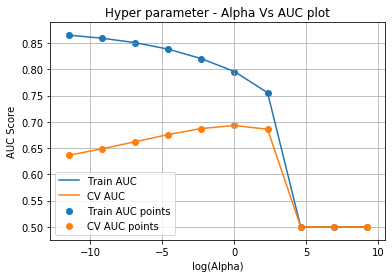

Best Hyperparameters: {'alpha': 1}
Best Alpha value for BoW: 1


In [22]:
# Plot AUC
best_alpha_bow = get_AUC_hyperparam_MultinomialNB(X_tr_bow, y_train)
print(f"Best Alpha value for BoW: {best_alpha_bow}")

With Bag of Words preprocessing


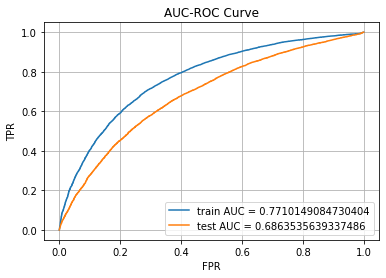

In [23]:
from sklearn.metrics import roc_curve, auc

# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
classifier_bow = MultinomialNB(alpha=best_alpha_bow, class_prior=[0.5, 0.5])
classifier_bow.fit(X_tr_bow, y_train)
# Using [:,1] in the code will give you the probabilities of getting the output as 1
# If you replace 1 with 0 in the above code, you will only get the probabilities of getting the output as 0.
y_train_pred = classifier_bow.predict_proba(X_tr_bow)[:,1]
y_test_pred = classifier_bow.predict_proba(X_te_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

print("With Bag of Words preprocessing")
plot_AUC_ROC_Curve(train_fpr, train_tpr, test_fpr, test_tpr)

In [24]:
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix for Bag of Words")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix for Bag of Words")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5023759372745285 for threshold 0.529
Train confusion matrix for Bag of Words
[[ 5274  2152]
 [12178 29437]]
Test confusion matrix for Bag of Words
[[ 3192  2267]
 [ 9482 21111]]


## Multinomial NB on these feature sets using TF-IDF Preprocessing

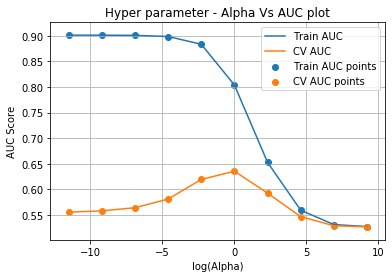

Best Hyperparameters: {'alpha': 1}
Best Alpha value for BoW: 1


In [25]:
# Plot AUC
best_alpha_tfidf = get_AUC_hyperparam_MultinomialNB(X_tr_tfidf, y_train)
print(f"Best Alpha value for BoW: {best_alpha_tfidf}")

With TF-IDF preprocessing


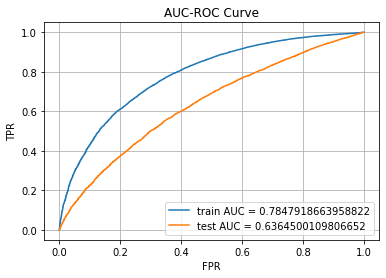

In [26]:
classifier_tfidf = MultinomialNB(alpha=best_alpha_tfidf, class_prior=[0.5, 0.5])
classifier_tfidf.fit(X_tr_tfidf, y_train)
# Using [:,1] in the code will give you the probabilities of getting the output as 1
# If you replace 1 with 0 in the above code, you will only get the probabilities of getting the output as 0.
y_train_pred = classifier_tfidf.predict_proba(X_tr_tfidf)[:,1]
y_test_pred = classifier_tfidf.predict_proba(X_te_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

print("With TF-IDF preprocessing")
plot_AUC_ROC_Curve(train_fpr, train_tpr, test_fpr, test_tpr)

In [27]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix for TF-IDF")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix for TF-IDF")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5079813841234232 for threshold 0.597
Train confusion matrix for TF-IDF
[[ 5281  2145]
 [11889 29726]]
Test confusion matrix for TF-IDF
[[ 2671  2788]
 [ 9155 21438]]


## Top 20 Features - TFIDF

In [28]:
max_ind_neg = np.argsort((classifier_tfidf.feature_log_prob_)[0])[::-1][0:20]
print(np.take(feature_name_list_tfidf, max_ind_neg))

['mrs' 'grades_prek_2' 'ms' 'math_science' 'grades_3_5'
 'literacy_language' 'mathematics' 'literacy' 'grades_6_8'
 'literature_writing' 'ca' 'health_sports' 'specialneeds'
 'appliedlearning' 'specialneeds' 'students' 'grades_9_12' 'mr'
 'appliedsciences' 'music_arts']


## Top 20 Features - Bag of Words

In [29]:
max_ind_neg = np.argsort((classifier_bow.feature_log_prob_)[0])[::-1][0:20]
print(np.take(feature_name_list_tfidf, max_ind_neg))

['students' 'school' 'learning' 'my' 'classroom' 'not' 'learn' 'they'
 'help' 'the' 'my students' 'nannan' 'many' 'we' 'need' 'work' 'come'
 'skills' 'love' 'able']


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [30]:
from IPython.display import HTML, display

data = [
        ['Vectorizer', 'Model', 'Alpha', 'AUC'],
        ['BoW', 'Multinomial NB', 1, 0.68],
        ['TF-IDF', 'Multinomial NB', 1, 0.63],
       ]

display(
    HTML('<table><tr>{}</tr></table>'.format(
               '</tr><tr>'.join(
                   '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
            )
    )
)

Vectorizer,Model,Alpha,AUC
BoW,Multinomial NB,1,0.68
TF-IDF,Multinomial NB,1,0.63
